#Податочно множество
Симнете го датасетот од линкот кој ви е поставен на самата задача, потоа истиот поставете го локално за да го вчитате.
Во случај на грешка при вчитување на .csv додадете аргумент `encoding='latin-1`


In [ ]:
! pip install transformers[torch] datasets evaluate

In [ ]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="/content/text_sentiment.csv")
dataset['train']

Dataset({
    features: ['text', 'Sentiment'],
    num_rows: 732
})

#Претпроцесирање кое е потребно

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
dataset['train'] = dataset['train'].add_column('label', encoder.fit_transform(dataset['train']['Sentiment']))
dataset['train'] = dataset['train'].remove_columns('Sentiment')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 732
    })
})

#Модел 1: Трансформер модел

In [ ]:
#nlptown/bert-base-multilingual-uncased-sentiment

In [ ]:
dataset = dataset['train'].train_test_split(test_size=0.2)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/585 [00:00<?, ? examples/s]

Map:   0%|          | 0/147 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", num_labels=191, ignore_mismatched_sizes=True) #kolku klasi ima

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([191, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([191]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
)

In [ ]:
import numpy as np
import evaluate
metric = evaluate.load("f1")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

In [ ]:
predictions = trainer.predict(tokenized_datasets['test'])
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels, preds))

#Модел 2: Невронска мрежа

In [ ]:
import pandas as pd
data = pd.read_csv('/content/text_sentiment.csv')
data.groupby(['Sentiment']).count()

,text
Sentiment,
Acceptance,8
Accomplishment,3
Admiration,4
Adoration,2
Adrenaline,1
...,...
Winter Magic,1
Wonder,3
Wonderment,1


In [ ]:
data.head(3)

,text,Sentiment
0,Awe-inspired by the grandeur of an ancient cat...,Awe
1,Awe-struck by the grandeur of an ancient cathe...,Awe
2,"Walking the Great Wall of China, each step a t...",Awe


In [ ]:
data['num_words'] = data['text'].apply(lambda x: len(x.split(" ")))

<Axes: ylabel='Frequency'>

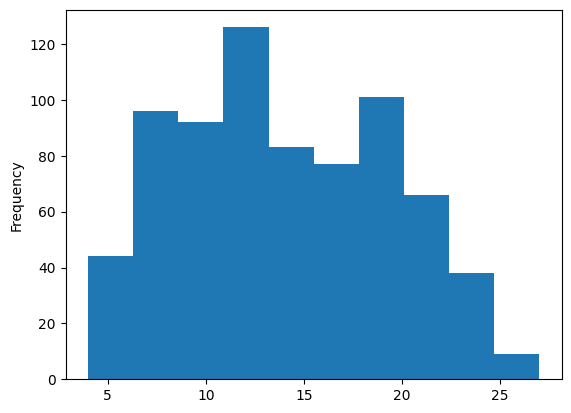

In [ ]:
data['num_words'].plot.hist()

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
vocabulary = 25

In [ ]:
x, y = data['text'], pd.get_dummies(data['Sentiment'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [ ]:
tokenizer = Tokenizer(num_words=vocabulary)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
x_test

[[2, 5, 8, 1],
 [2, 8, 2],
 [2, 4, 2, 7, 1, 3, 7],
 [5, 1, 8, 1],
 [2, 7, 1, 19, 1, 3],
 [2],
 [2, 24, 2, 3],
 [5, 1, 8, 1],
 [1, 1, 19, 4, 1, 21, 2, 3, 7],
 [16, 1, 1, 8, 2, 3, 1, 3],
 [2, 7, 19, 1, 14],
 [2, 4, 1, 4, 1, 3, 7],
 [4, 2, 18, 19, 5],
 [1, 1, 1, 2, 4, 1],
 [5, 1, 9, 15, 24, 1, 2],
 [5, 15, 6, 2, 15],
 [10, 1, 3, 2, 6, 7],
 [11, 2, 1, 3, 2, 3],
 [4, 1, 3, 2, 2, 3, 2, 3, 7],
 [4, 10, 1],
 [1, 2],
 [1, 3, 1],
 [4, 1, 2, 3, 18, 1],
 [1, 20, 2, 14],
 [10, 1, 3, 4, 12],
 [4, 1, 3, 2],
 [10, 1, 3, 1],
 [4, 1, 3, 19, 2, 1, 4],
 [2, 3, 13, 1, 3, 3],
 [1, 8, 2, 3, 4, 1],
 [2, 4, 1, 3, 17, 2, 3],
 [2, 4, 1, 3, 1, 19, 7, 21, 2, 3],
 [4, 1, 3, 2, 2, 5, 8, 1, 5, 1],
 [4, 1, 3, 1, 4, 9, 2, 3, 7],
 [16, 1, 3, 1],
 [2, 4, 1, 3, 2, 5],
 [13, 1, 3],
 [1, 3, 1, 2, 5, 9, 1, 3],
 [16, 1, 5, 2],
 [1, 2, 2, 8, 2, 3, 5, 1],
 [10, 2],
 [1, 3, 2],
 [1, 3, 2],
 [13, 1, 3, 17, 1, 6, 3],
 [1, 3, 12, 1, 19, 5, 2, 17, 3, 1],
 [1, 3, 2, 18, 1, 3],
 [4, 1, 3, 1, 4, 6],
 [2, 3, 10, 1, 3],
 [1, 3, 9, 2],
 [

(array([38., 80., 85., 93., 73., 77., 51., 56., 20., 12.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

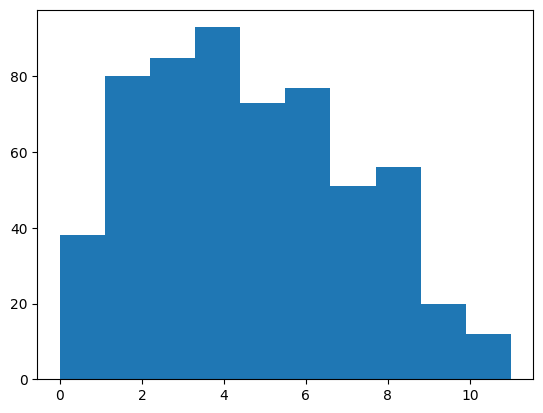

In [ ]:
len_tokens = [len(token_list) for token_list in x_train]
plt.hist(len_tokens)

In [ ]:
max_token_length = 10

In [ ]:
x_train = sequence.pad_sequences(x_train, maxlen=max_token_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_token_length)

In [ ]:
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten, Dropout
from sklearn.metrics import classification_report
from keras.layers import Input, Embedding, LSTM, Dense, concatenate

In [ ]:
model = Sequential()
model.add(Embedding(max_token_length, 32, input_length=x_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(191, activation='softmax'))

In [ ]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=8, epochs=3)

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node sequential_9/embedding_7/embedding_lookup defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-87-ac10bcb192bf>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 272, in call

indices[0,8] = 19 is not in [0, 10)
	 [[{{node sequential_9/embedding_7/embedding_lookup}}]] [Op:__inference_train_function_37680]

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

In [ ]:
preds = model.predict(x_test)

In [ ]:
print(classification_report(np.argmax(y_test.values, axis=1), np.argmax(preds, axis=1)))

#Eвалуација на двата модели и споредба